In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240922%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240922T160409Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8d4ac5b388b7074ead30857113b9230bd76d47961b4554b8c5e32ad3ce24ba9b0c2d86abd5d714effbb1eaefe7651597957915fa4d58f7400fc1123c42b6314c4bb25f1996a8fca919306cfc9463a27fa1c50f5909fe98afe626f807a2fd9e02ac783008fe47272a5d31dda741f72f6c9f4c7de2bb242254879959a309084e7f1a4510f9b7a6290f39290eed9a1c484d8bf91a865039712563de3bcb95bdfea8998e0cf8ed2a7cc5cb8d0c9899ed36350065a8b081b08e31e135f9262713e816011540d9b515113142c60edb762f8c53e6966412cbda37e899adfdcc1fbc796a8c9908c0d31d39972efb79363c8535e5febf9c3c951a8497928a2044ab583ae3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
Data source import complete.


# Import Modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

warnings.filterwarnings('ignore')

# Load the dataset

In [3]:
paths = []
labels = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [4]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_mouse_sad.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_learn_sad.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_sell_sad.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_have_sad.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_far_sad.wav']

In [5]:
labels[:5]

['sad', 'sad', 'sad', 'sad', 'sad']

In [6]:
# Create a DataFrame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,sad
1,/kaggle/input/toronto-emotional-speech-set-tes...,sad
2,/kaggle/input/toronto-emotional-speech-set-tes...,sad
3,/kaggle/input/toronto-emotional-speech-set-tes...,sad
4,/kaggle/input/toronto-emotional-speech-set-tes...,sad


In [7]:
df['label'].value_counts()

,count
label,
sad,800
angry,800
fear,800
neutral,800
ps,800
disgust,800
happy,800


# Exploratory Data Analysis

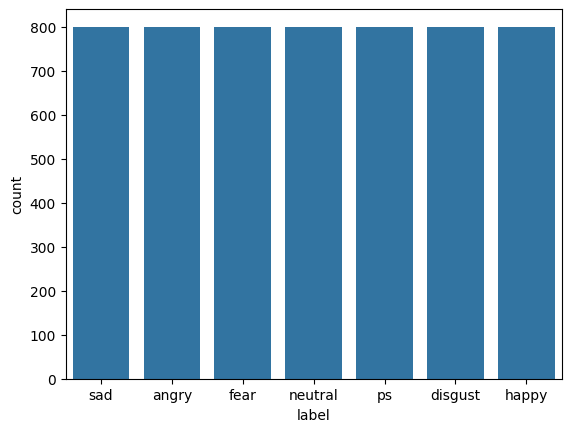

In [8]:
sns.countplot(x = df['label'])
plt.show()

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize = (10,4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize = (10,4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()

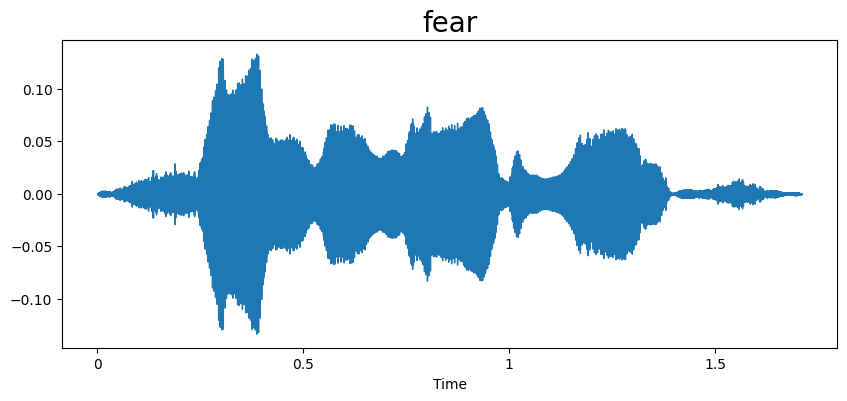

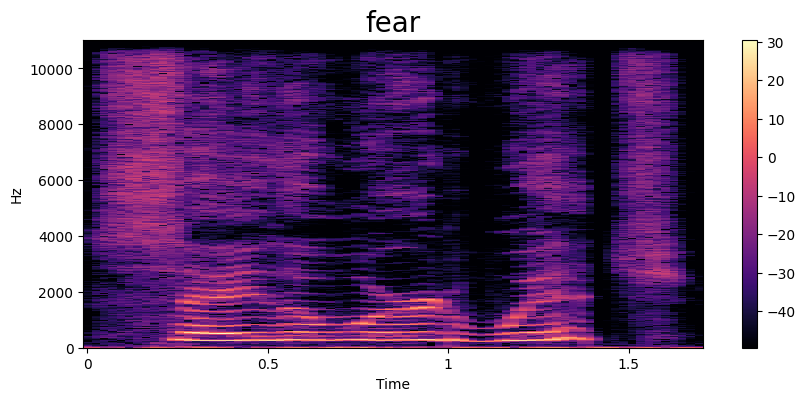

In [12]:
emotion = 'fear'
# Ensure the 'label' column exists and contains the emotion 'fear'
if 'label' in df.columns and emotion in df['label'].values:
    path = df.loc[df['label'] == emotion, 'speech'].iloc[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
    Audio(path)
else:
    print(f"No audio files found with the label '{emotion}'.")
    # Check unique values in the 'label' column for potential inconsistencies:
    print(f"Unique values in 'label' column: {df['label'].unique()}")

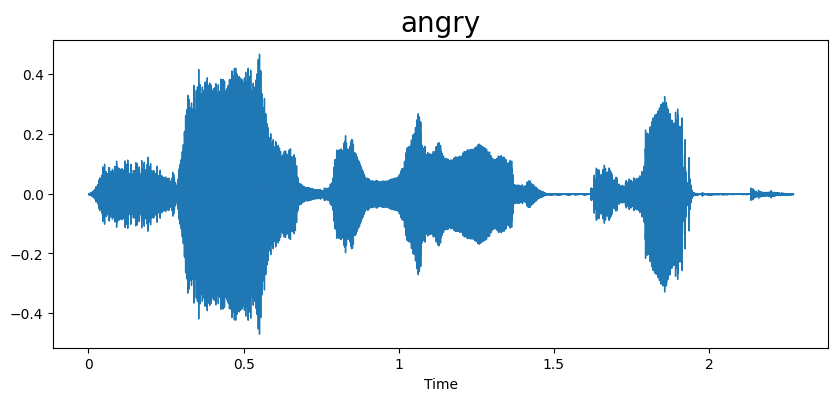

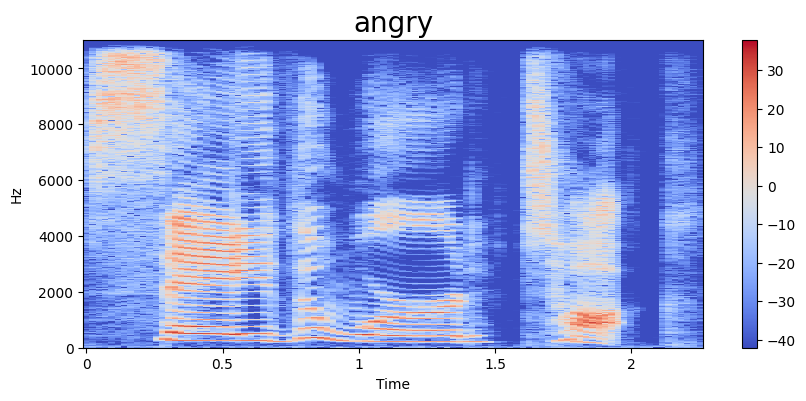

In [13]:
emotion = 'angry'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

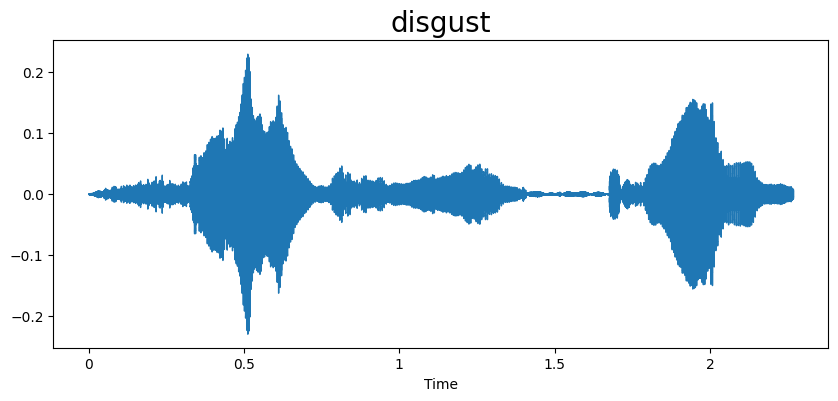

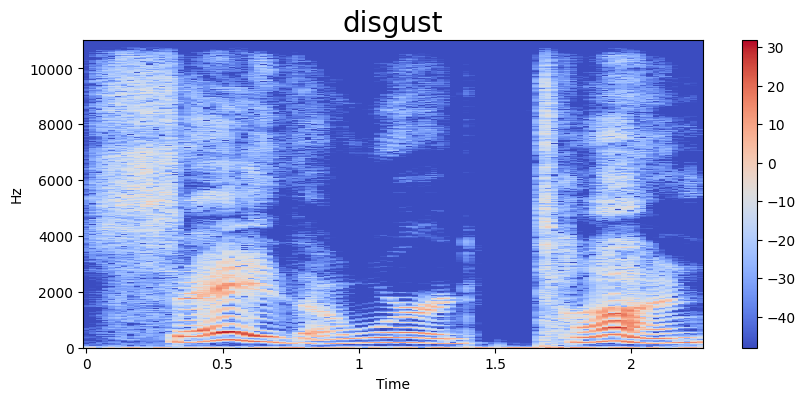

In [14]:
emotion = 'disgust'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

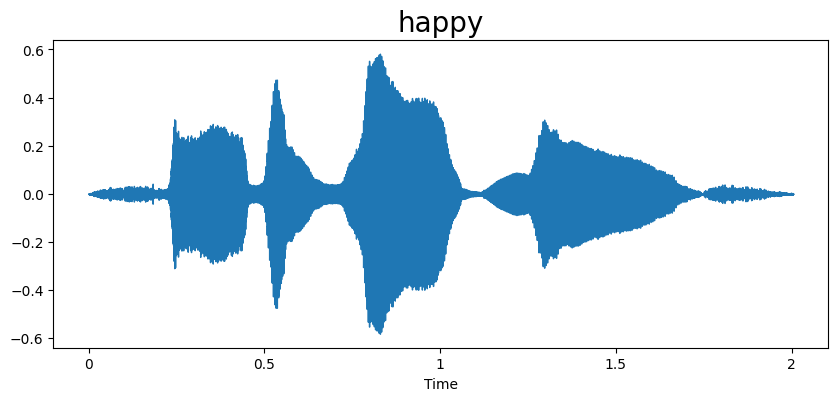

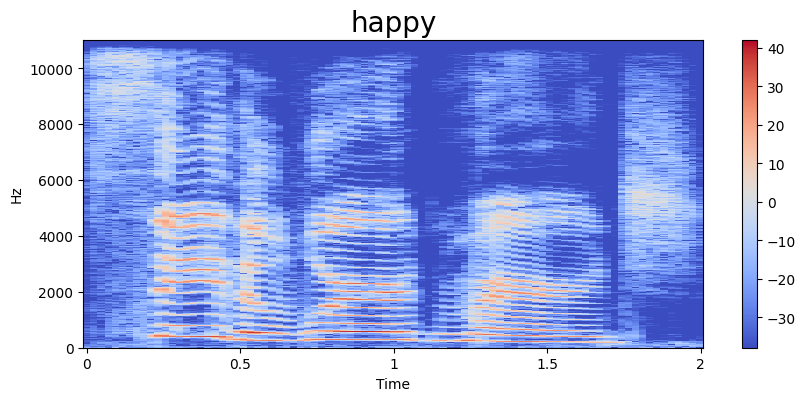

In [15]:
emotion = 'happy'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

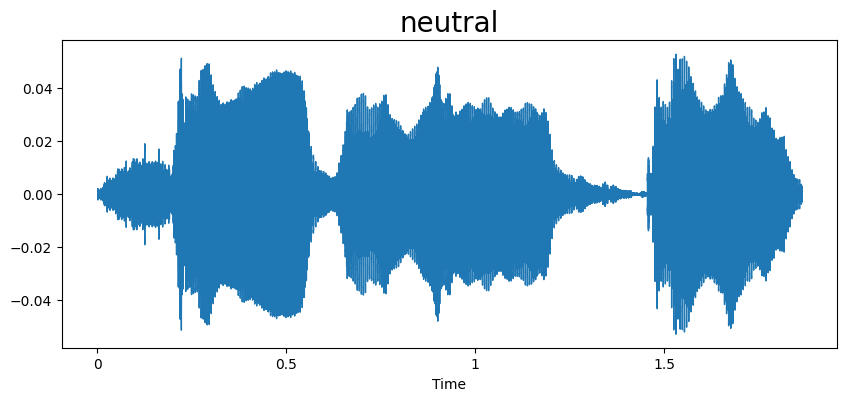

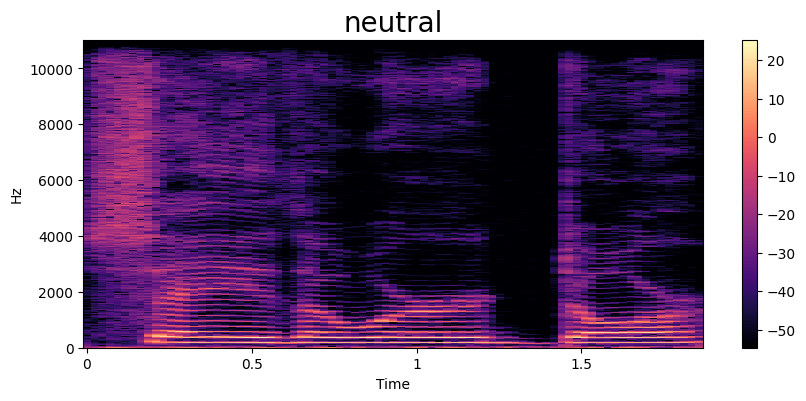

In [16]:
emotion = 'neutral'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

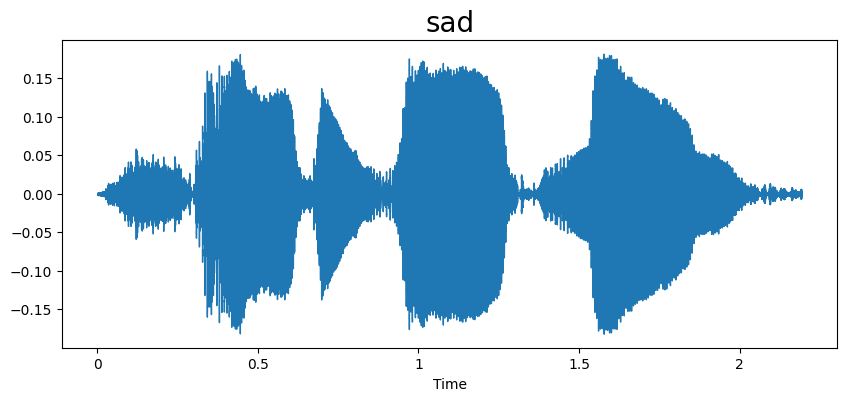

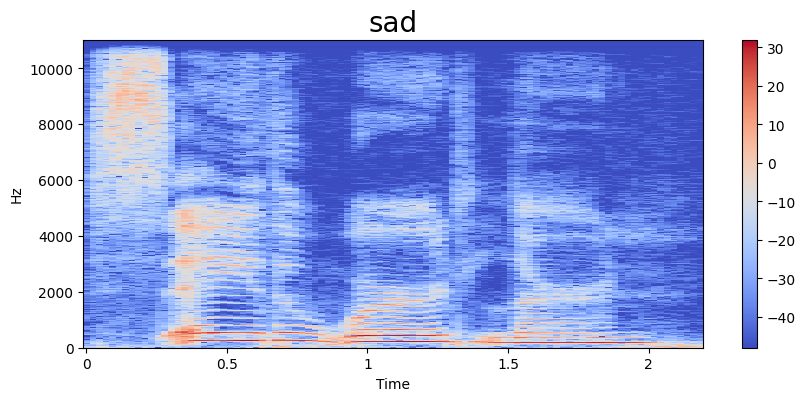

In [17]:
emotion = 'sad'
path = np.array(df['speech'][df['label'] == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

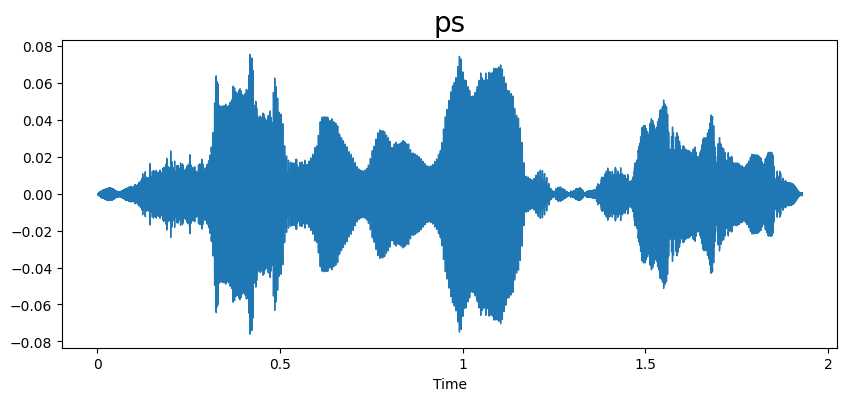

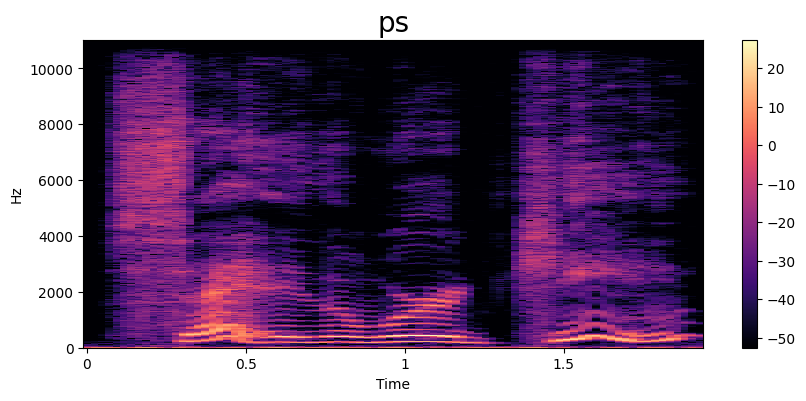

In [18]:
emotion = 'ps'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Feature Extraction

In [19]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 0.3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr,n_mfcc=40).T, axis = 0)
    return mfcc

In [20]:
extract_mfcc(df['speech'][0])

array([-3.5227917e+02,  6.1676140e+01,  3.2790909e+01,  5.8858879e+01,
       -2.9226832e+00, -1.0509627e+01, -6.9924426e+00, -1.8300367e+01,
       -6.3180346e+00, -1.7545992e+01, -6.5527139e+00, -3.4867291e+00,
       -1.5247162e+01,  1.0740133e+01, -8.3347273e+00, -5.5034657e+00,
        3.8537245e+00, -4.5217099e+00, -1.2770135e+01, -1.2149001e+01,
       -1.3188028e+01, -8.2677450e+00,  6.2160258e+00,  1.6904051e+01,
        2.1871870e+01,  3.6101753e+01,  1.8465807e+01,  1.0881008e+01,
       -9.3427455e-01, -3.5323362e+00, -4.0718179e+00,  4.2944469e+00,
        1.7669500e+00, -1.4845593e+00, -7.7020950e+00,  2.2747684e+00,
       -5.5407766e-02, -7.1755528e-01, -8.6432772e+00, -2.9466002e+00],
      dtype=float32)

In [21]:
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [22]:
x_mfcc

,speech
0,"[-352.27917, 61.67614, 32.79091, 58.85888, -2...."
1,"[-353.71222, 77.8155, 25.871355, 56.40878, -6...."
2,"[-348.60104, 75.546425, 23.455553, 44.5732, -5..."
3,"[-369.90067, 70.22376, 26.006, 46.491272, -6.3..."
4,"[-342.92435, 58.666565, 36.576714, 58.19635, -..."
...,...
5595,"[-405.96002, 104.0948, 28.147865, 16.0364, 12...."
5596,"[-437.6491, 89.9045, 40.51912, 14.115777, 17.1..."
5597,"[-413.54913, 96.28871, 21.18903, 13.508704, 8...."
5598,"[-426.35876, 96.011055, 8.07099, 10.20832, 22...."


In [23]:
x = [x for x in x_mfcc]
x = np.array(x)
x.shape

(5600, 40)

In [24]:
# input Split
x = np.expand_dims(x, -1)
x.shape

(5600, 40, 1)

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [26]:
y = y.toarray()

In [27]:
y.shape

(5600, 7)

# Create the LSTM Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential([
    LSTM(123, return_sequences = False, input_shape = (40,1)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 123)                 │          61,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(x, y, validation_split= 0.2, epochs = 50, batch_size = 64, shuffle = True)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4133 - loss: 1.6063 - val_accuracy: 0.3375 - val_loss: 1.5275
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7011 - loss: 0.7638 - val_accuracy: 0.6384 - val_loss: 0.8921
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8506 - loss: 0.4353 - val_accuracy: 0.8223 - val_loss: 0.5520
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8899 - loss: 0.3232 - val_accuracy: 0.8366 - val_loss: 0.4822
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8899 - loss: 0.3248 - val_accuracy: 0.8277 - val_loss: 0.5103
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9104 - loss: 0.2531 - val_accuracy: 0.8875 - val_loss: 0.3392
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9177 - loss: 0.2326 - val_accuracy: 0.8500 - val_loss: 0.3516
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9196 - loss: 0.2232 - val_accuracy: 0.8946 - val_loss

# Plot the results

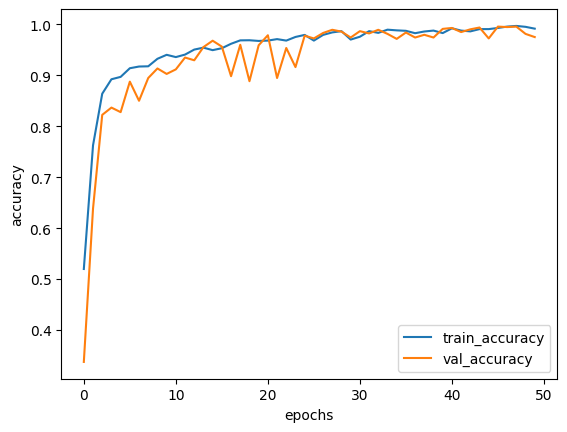

In [32]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label = 'train_accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

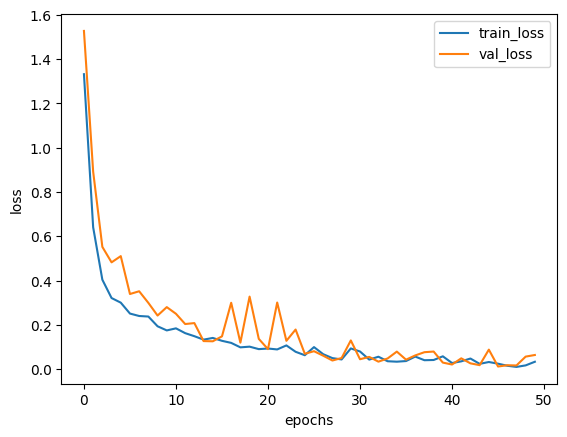

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label = 'train_loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Displaying Best Accuracy and Loss Values

In [34]:
best_train_acc = max(acc)
best_val_acc = max(val_acc)

print(f"Best Training Accuracy: {best_train_acc * 100:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Training Accuracy: 99.69%
Best Validation Accuracy: 99.55%


In [35]:
best_train_loss = min(loss)
best_val_loss = min(val_loss)

print(f"Lowest Training Loss: {best_train_loss:.4f}")
print(f"Lowest Validation Loss: {best_val_loss:.4f}")

Lowest Training Loss: 0.0098
Lowest Validation Loss: 0.0117
